In [1]:
import os
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', -1)
import re
import math
import numpy as np
import pickle
import json
from json import JSONDecodeError
from collections import Counter, defaultdict
from urllib.parse import urlparse
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import scipy.stats as stats
from textblob import TextBlob
from IPython.display import display, Image

from utils import clean_s, clean_url, corr_data
from regress_reddit import DataGetter, LinReg

There are two primary classes: `DataGetter` and `LinReg`. `DataGetter` loads, filters, featurizes, transforms, and otherwise prepares the data for regression. `LinReg` fits the actual regression model(s).

We can first create a `DataGetter` object to start preparing some data for a regression. The `__init__()` function takes only the name of the data source as an argument.

In [2]:
DG = DataGetter('posts_with_words.pkl')

We can see that the `out_dir` attribute has been initialized, but the `data` and `feats_dict` fields have yet to be initialized. 

In [3]:
DG.__dict__

{'data_fname': 'posts_with_words.pkl',
 'out_dir': '/u/scr/yiweil/Green-American-Lexicon/3_reddit_analysis/posts_with_words.pkl_out',
 'feats_dict': None,
 'data': None}

In [4]:
assert os.path.exists(DG.get_out_dir())

To initialize `self.data`, we call the `load_data()` function:

In [5]:
DG.load_data()
print('Shape of data:',DG.get_data().shape)


Loading data from /u/scr/yiweil/Green-American-Lexicon/3_reddit_analysis/reddit_data/posts_with_words.pkl...
Read data from with dimensions (911496, 36).
Shape of data: (911496, 36)


There are various criteria according to which we'll want to filter the loaded data--excluding posts by bots, from irrelevant subreddits, from subreddits that have been miscategorized and which are actually users, AskMeAnything and ChangeMyView posts--by default these are all set to `True`. 

In addition, by setting `hi_prec_keyword_filter` to `True`, we keep only the posts with at least 2 distinct high precision keywords.

In [6]:
DG.filter_data()


Filtering data...
Excluding posts from 2895 bot users...
	New size of posts: 869922
Excluding posts from 14186 irrelevant subreddits...
	New size of posts: 702917
Excluding posts from a false subreddit that's actually a user...
	New size of posts: 702917
Excluding AMA-type posts...
	New size of posts: 702145
Excluding CMV-type posts...
	New size of posts: 700969
Filtering to posts that contain at least 2 distinct high precision keywords...
	New size of posts: 578861


But we could also do something like `DG.filter_data(exclude_cmv=False)` if we wanted to keep CMV posts.

Now we get the actual features. In some cases, the keyword args map onto multiple individual features (e.g., setting `sentistrength` to `True` will compute both the positive and negative scores for a post).

The repository by default includes files containing every one of the below features, pre-computed, and so running the below block will load those cached feature files. If you wish to have the features computed from scratch (which would be necessary if you use a different set of posts entirely), just move the cached feature files to a different location.

These are the default settings used in my regressions (i.e., `wiebe_subjectivity` and `NRC` are not added as features): 

```
DG.get_features(length=True, url=True, top_N_domains=20, people=True, sentistrength=False, vader=True, 
                textblob=True, wiebe_subjectivity=False, NRC=False, neg=True, nat_disaster=True,
                economy=True, emolex=True, morals=True, values=True)
```

In [ ]:
DG.get_features(length=True, url=True, top_N_domains=20, people=True, sentistrength=False, vader=True, 
                textblob=True, wiebe_subjectivity=True, NRC=True, neg=True, nat_disaster=True,
                economy=True, emolex=True, morals=True, values=True)


Adding features...
Adding length feature...
	Done!
Adding cached URL-related features...
	Done!
Adding people-mention features...
	Done!
Found cached feature file at /u/scr/yiweil/Green-American-Lexicon/3_reddit_analysis/posts_with_words.pkl_out/VADER_scores_concatenated.tsv. Adding cached VADER features...
	Done!
Found cached feature file at /u/scr/yiweil/Green-American-Lexicon/3_reddit_analysis/posts_with_words.pkl_out/textblob_scores.pkl. Adding cached TextBlob features...
	Done!
Found cached feature file at /u/scr/yiweil/Green-American-Lexicon/3_reddit_analysis/posts_with_words.pkl_out/NRC_scores.pkl. Adding cached NRC features...
	Done!
Found cached feature file at /u/scr/yiweil/Green-American-Lexicon/3_reddit_analysis/posts_with_words.pkl_out/wiebe_scores.pkl. Adding cached Wiebe et al. subjectivity features...
	Done!
Computing negation feature...
	Done!
Computing natural disaster feature...
	Done!
Computing economy feature...
	Done!
Found cached feature file at /u/scr/yiweil/Gr

We see that there are now a lot more columns for the retrieved features:

In [ ]:
dg_data = DG.get_data()
len(dg_data.columns)

For example, here are the indicator variables for people:

In [ ]:
[x for x in dg_data.columns if x.startswith('has_')]

To get categorical versions of continuous features, use the `get_categorical_features` function, which takes the same format of keyword arguments. 

For the positive and negative SentiStrength features, the function maps scores with absolute value > 1 to 1, and scores with absolute value == 1 to 0.

For all other features, the function maps the categorical feature for a given post to 1 if the feature for that post is greater than or equal to the median of non-zero values for that feature, and 0 otherwise. You can also create thresholds based on the mean by passing `threshold=mean` as a keyword argument.

In [ ]:
DG.get_categorical_features(vader_pos=True,vader_neg=True,tb_sub=True,
                            emo_anger=True,emo_anticipation=True,emo_disgust=True,
                            emo_fear=True,emo_joy=True,emo_sadness=True,emo_surprise=True,
                            emo_trust=True,negation=True,nat_dis=True,econ=True,
                            vice_purity=True,vice_harm=True,vice_authority=True,
                            vice_fairness=True,vice_loyalty=True,
                            virtue_purity=True,virtue_harm=True,virtue_authority=True,
                            virtue_fairness=True,virtue_loyalty=True,
                            self_direction=True,stimulation=True,hedonism=True,achievement=True,power=True,
                            security=True,conformity=True,tradition=True,benevolence=True,universalism=True)

The below function fills in `self.feats_dict`, to make it easier to keep track of which (types of) features (and feature names) have been added to the data.

In [ ]:
DG.set_features()

So now, each type of feature given in the keys of `DG.get_feats_dict()` maps to a list containing all of the retrieved feature of that type.

The key `non_categorical` maps onto all features, excluding the categorical versions of continuous features obtained using `get_categorical_features()`, so it actually includes features that are inherently categorical like the indicator variables. The key `categorical` maps onto all features, but not including the categorical versions of continuous features and excluding the original continuous versions.

In [ ]:
pd.DataFrame.from_dict(DG.get_feats_dict(),orient='index')

In [ ]:
# TO DO: update above to
dg_feats_dict = DG.get_feats_dict(ipython_disp=True)

We also need to z-score the features to make the coefficients comparable, and to create residualized features using the residual of length regressed on each feature (since most features are highly correlated with length). 

In [13]:
DG.get_zscores()


Getting zscores...
	Done!


By default, the `resid_by` argument of `get_residuals` is set to `log_len`.

In [14]:
DG.get_residuals()


Getting residuals...
	Done!


Now, there are additional columns for features that have been zscored and residualized, except `log_len`, which has just been zscored:

In [15]:
[x for x in dg_data.columns if x.endswith('zscore_resid')][:10]

['emo_anger_zscore_resid',
 'emo_trust_zscore_resid',
 'NRC_dom_zscore_resid',
 'benevolence_zscore_resid',
 'tb_pol_zscore_resid',
 'emo_sadness_zscore_resid',
 'vice_authority_zscore_resid',
 'NRC_arousal_zscore_resid',
 'emo_fear_zscore_resid',
 'achievement_zscore_resid']

In [16]:
assert 'log_len_zscore' in dg_data.columns and 'log_len_zscore_resid' not in dg_data.columns

And we can also visualize the general distributions for different features:


Creating figures...


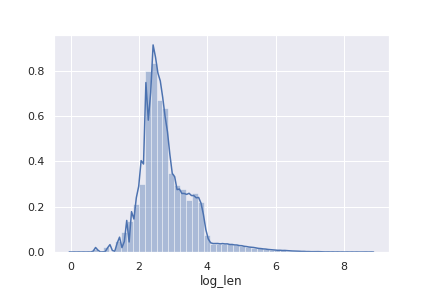

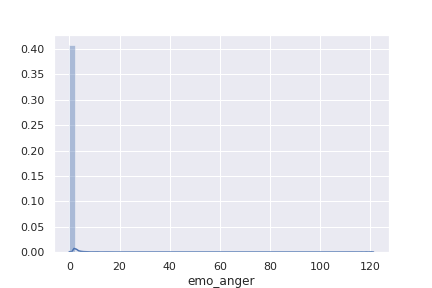

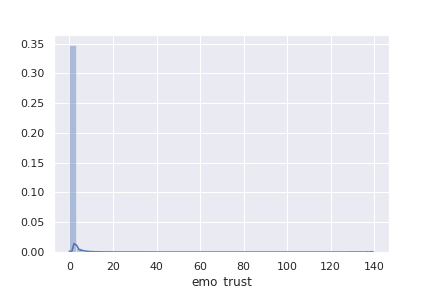

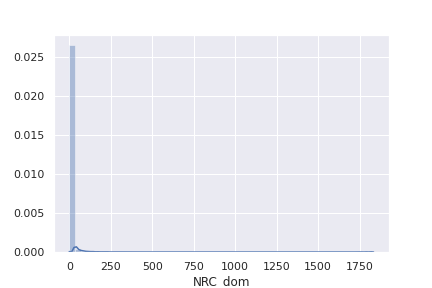

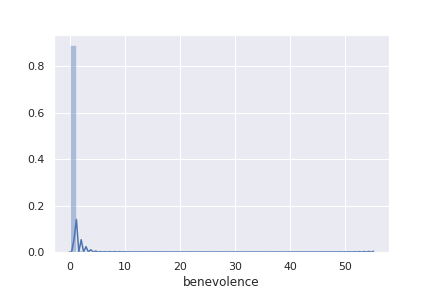

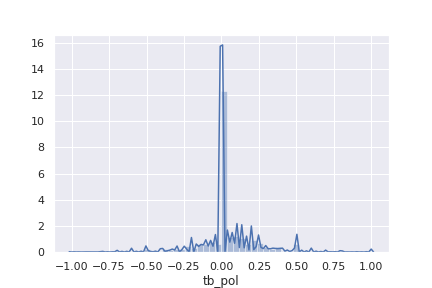

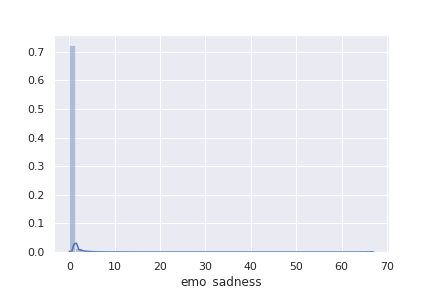

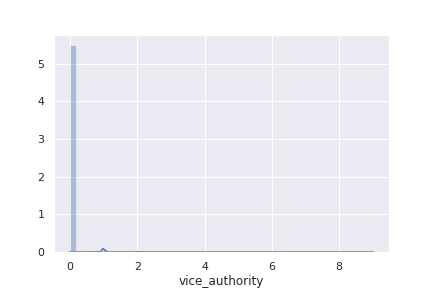

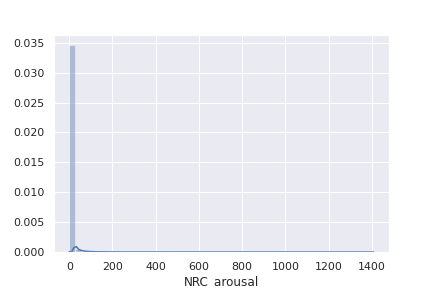

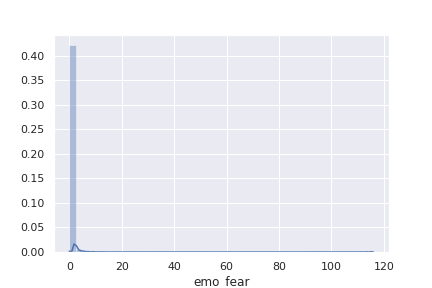

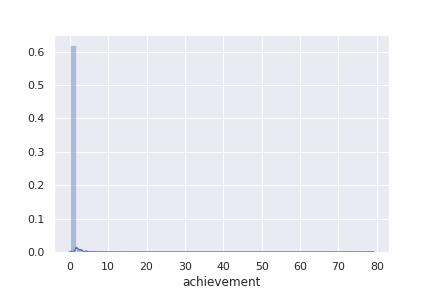

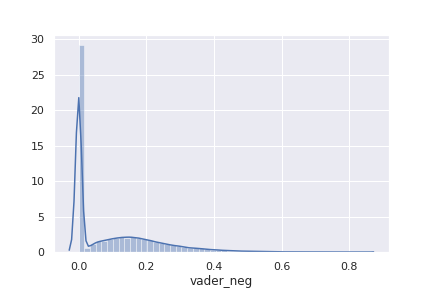

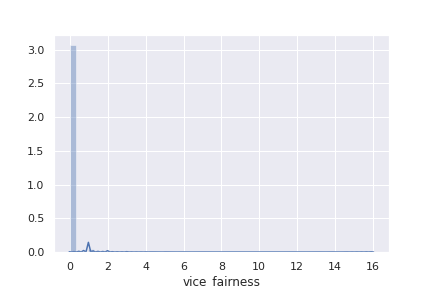

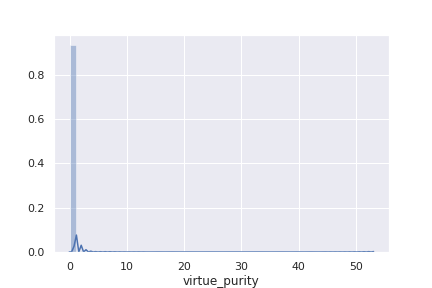

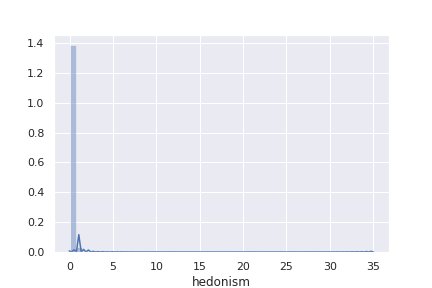

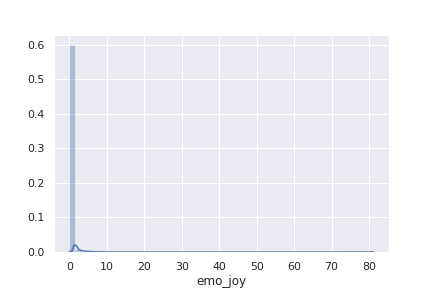

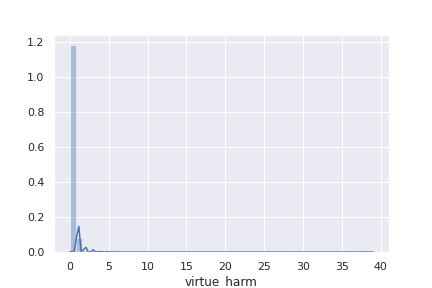

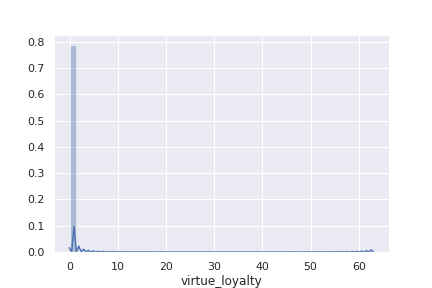

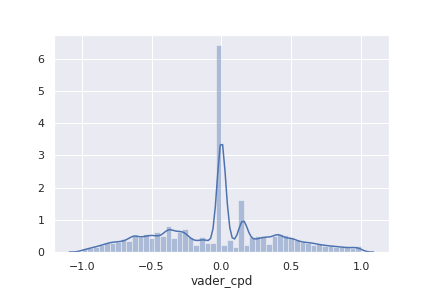

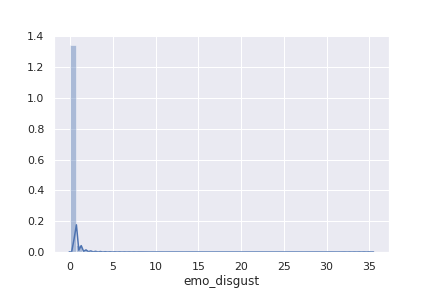

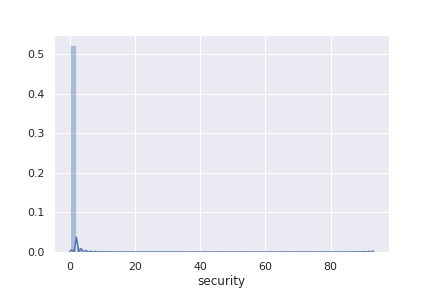

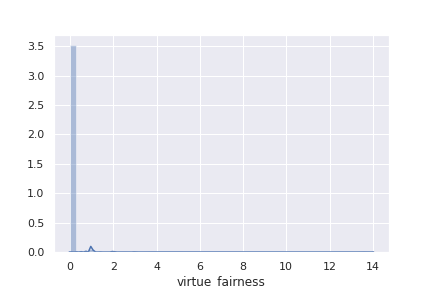

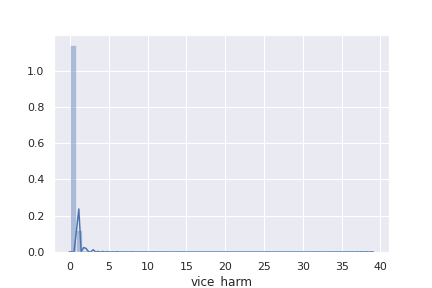

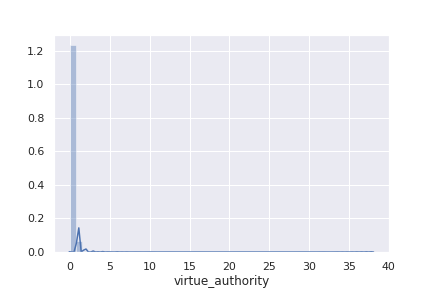

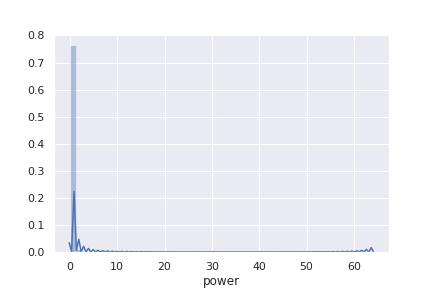

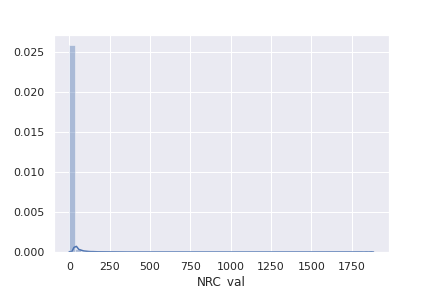

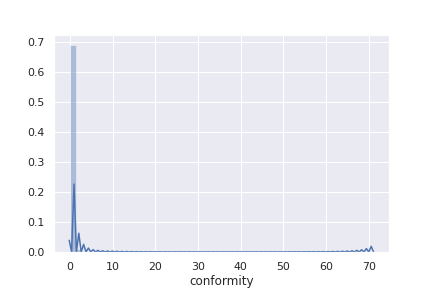

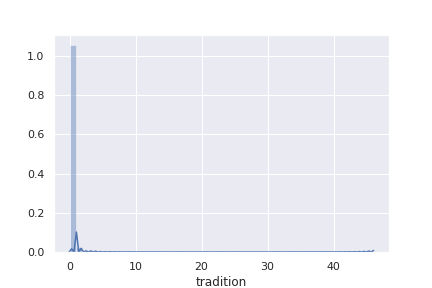

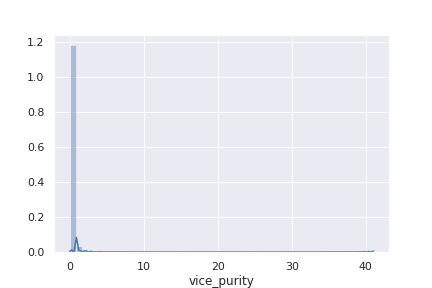

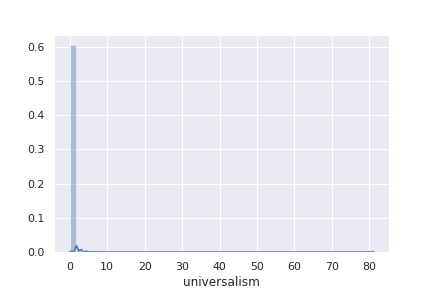

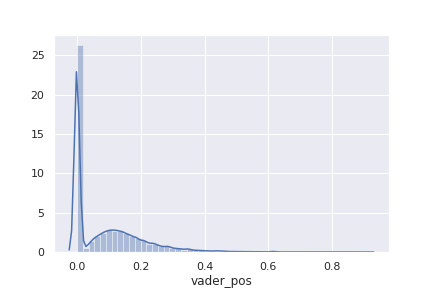

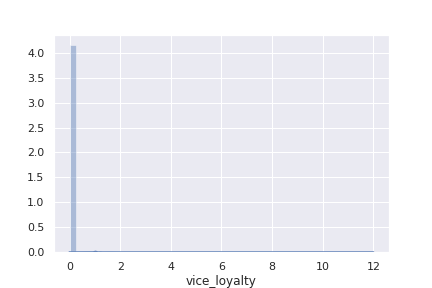

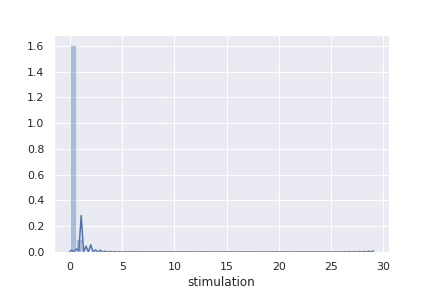

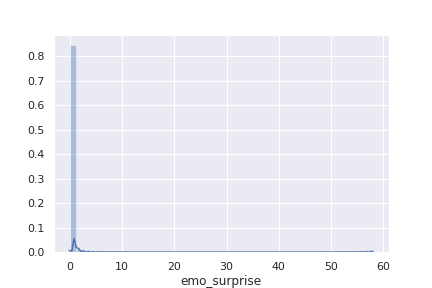

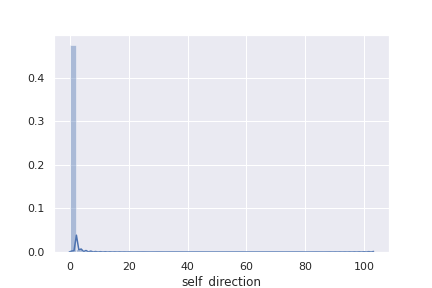

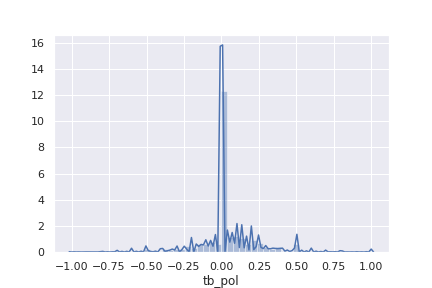

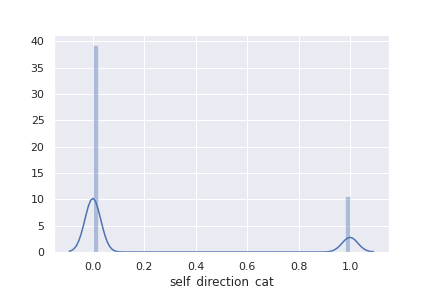

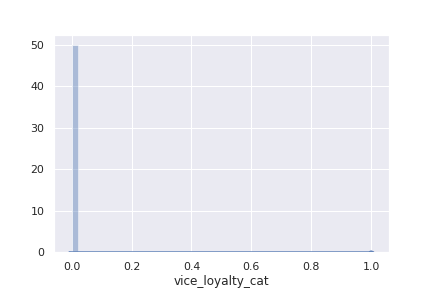

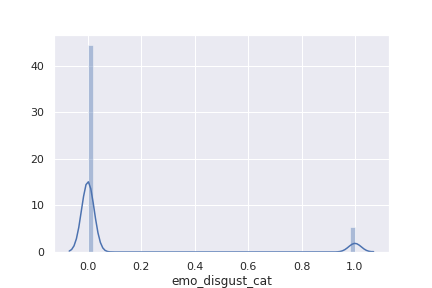

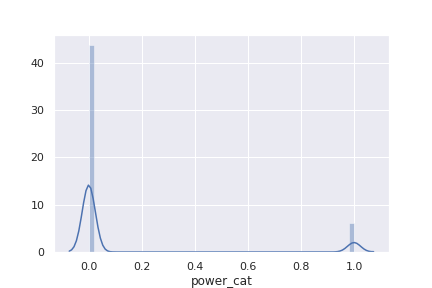

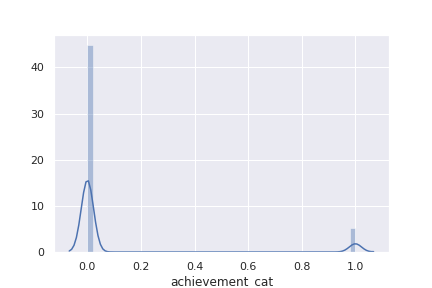

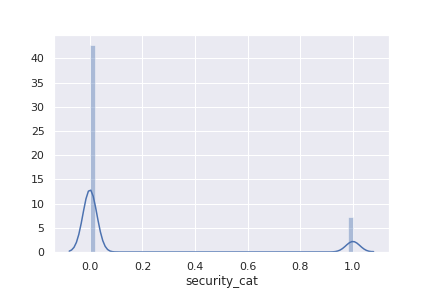

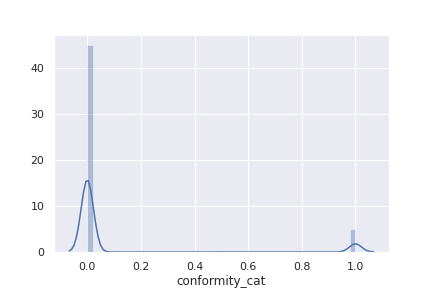

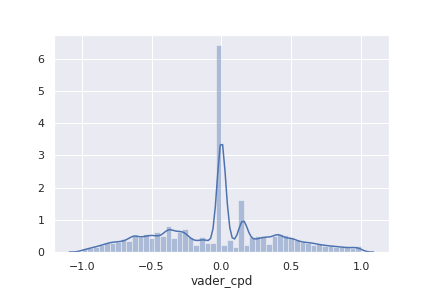

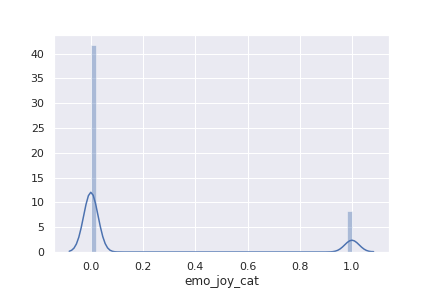

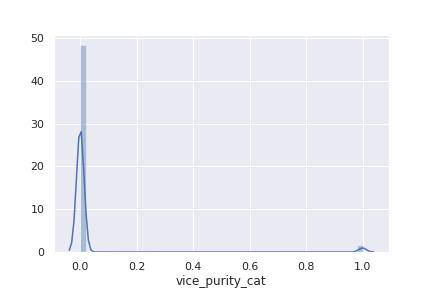

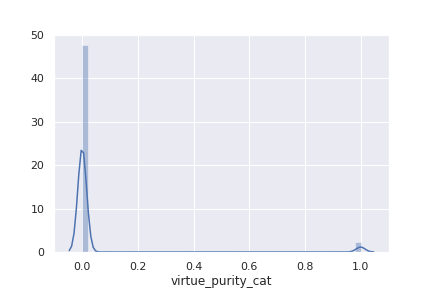

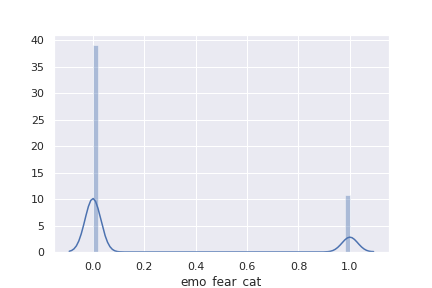

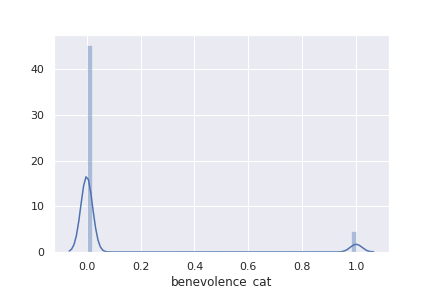

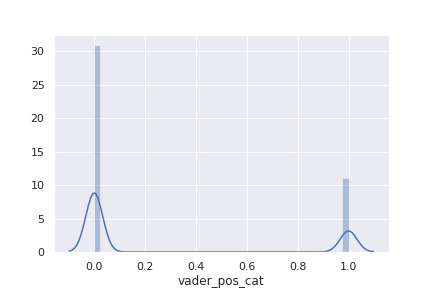

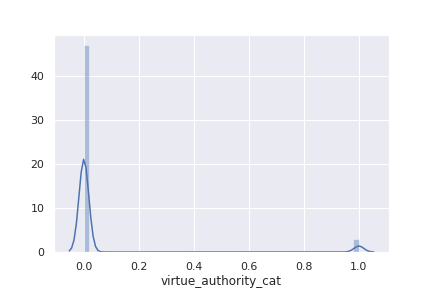

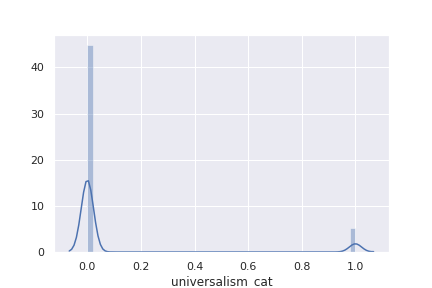

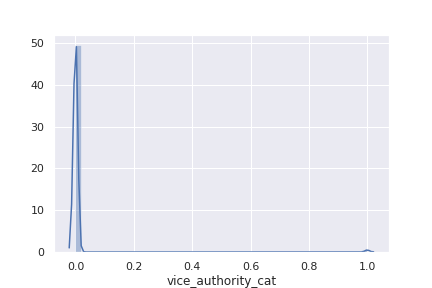

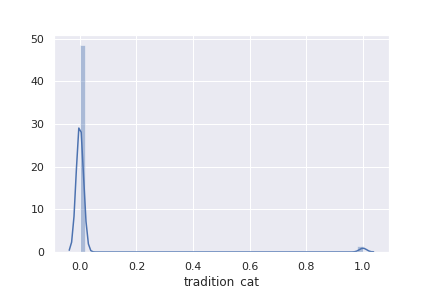

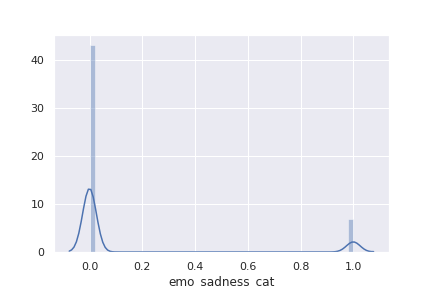

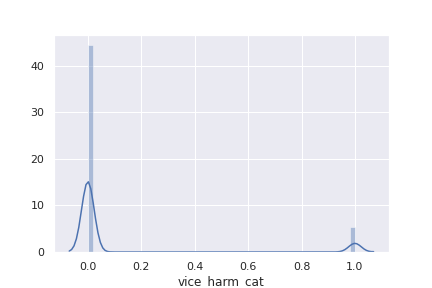

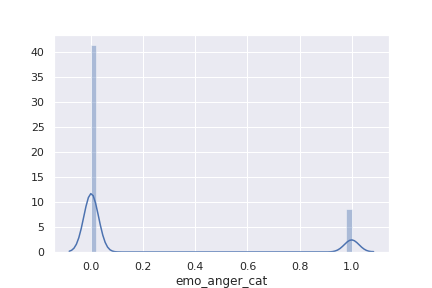

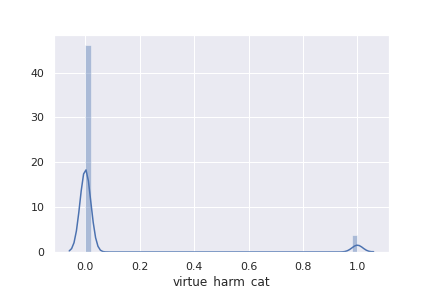

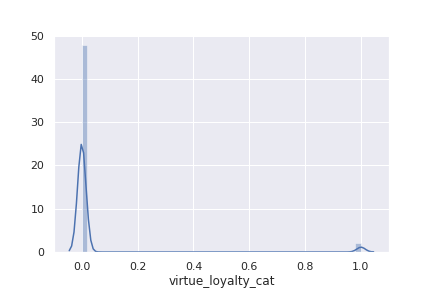

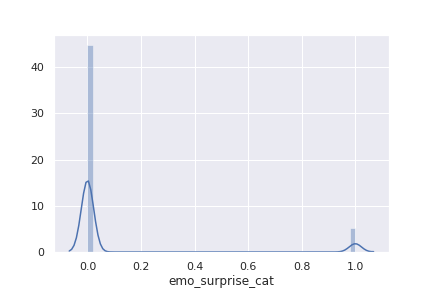

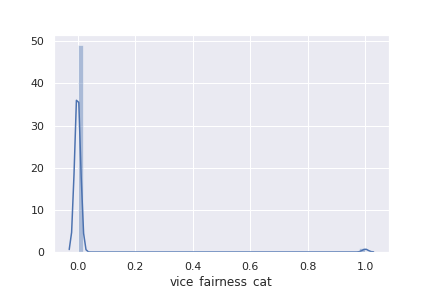

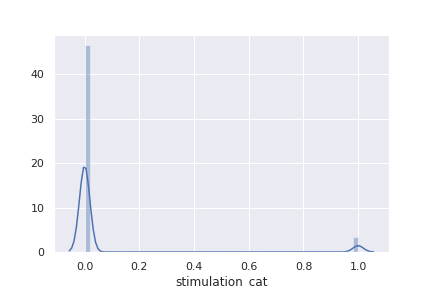

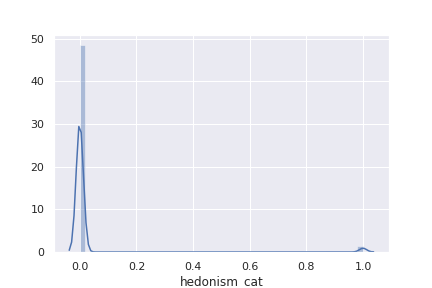

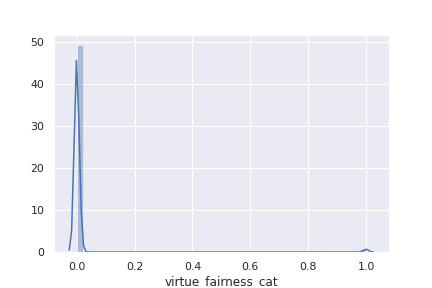

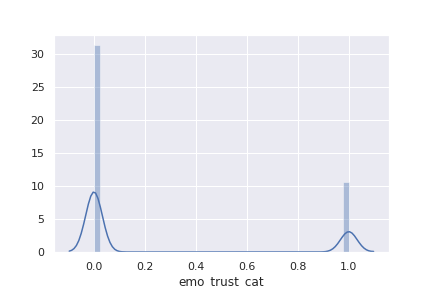

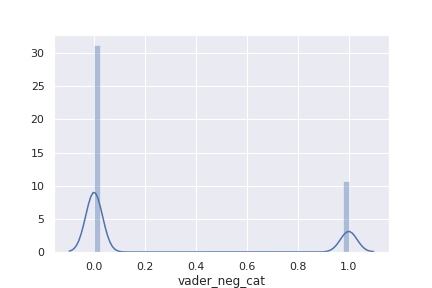

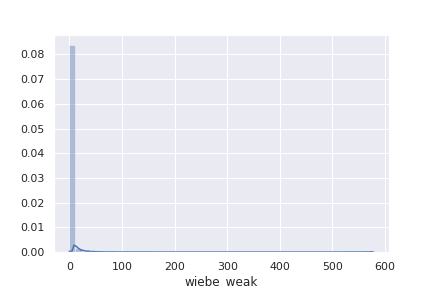

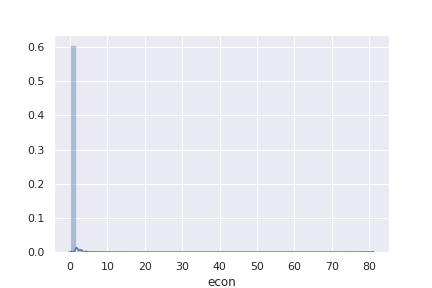

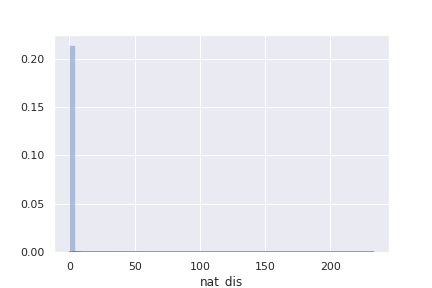

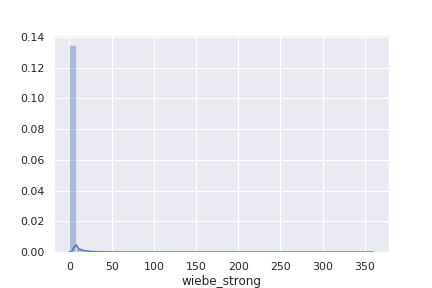

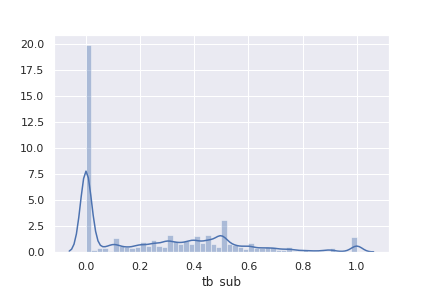

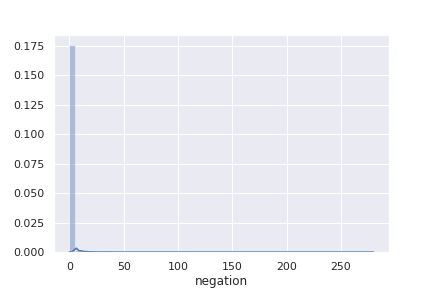

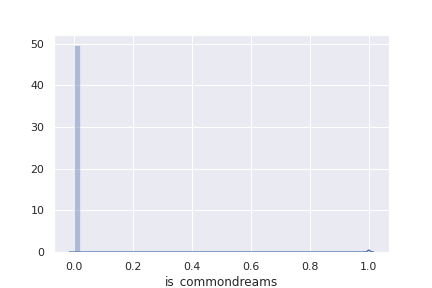

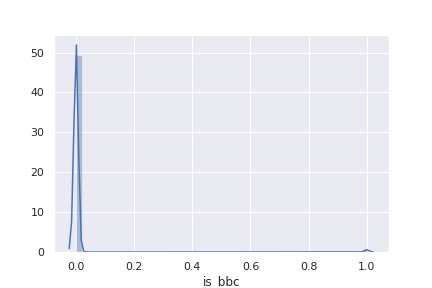

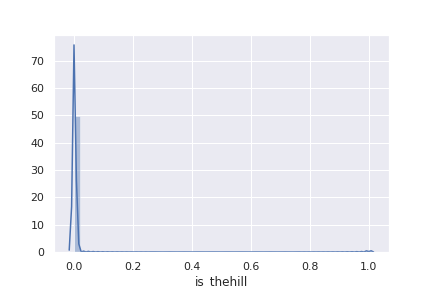

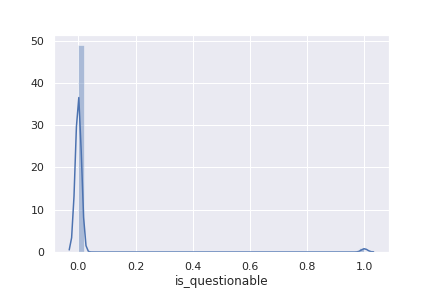

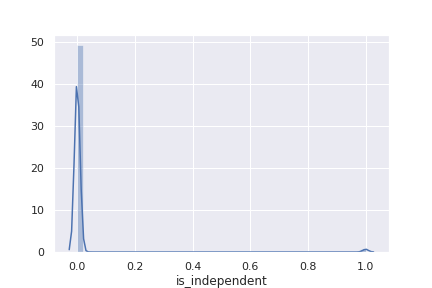

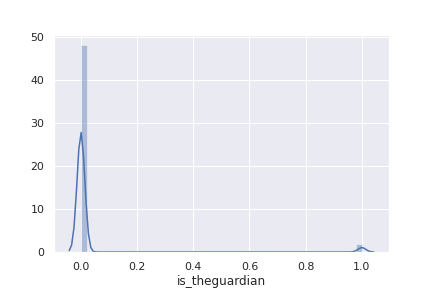

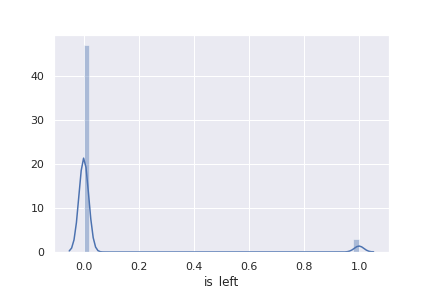

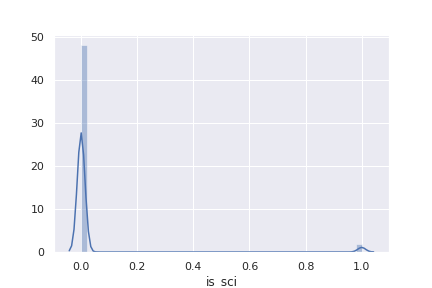

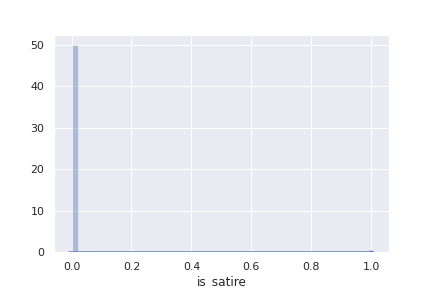

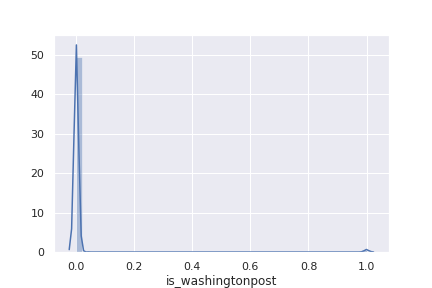

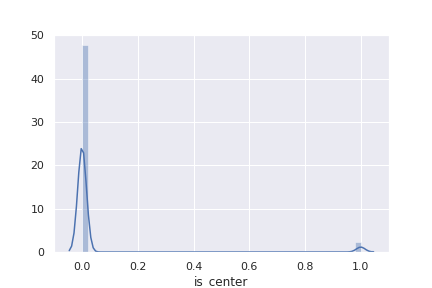

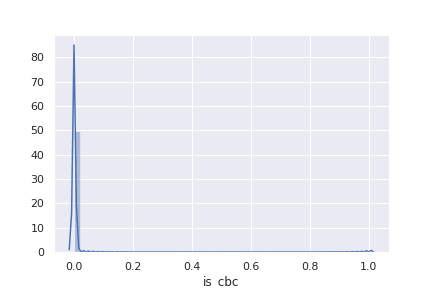

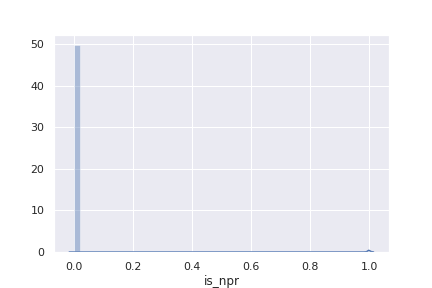

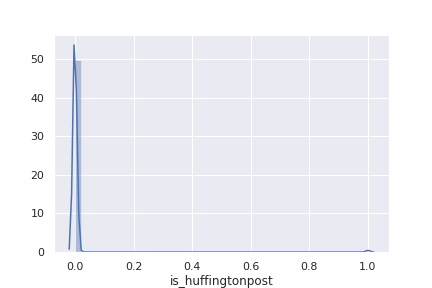

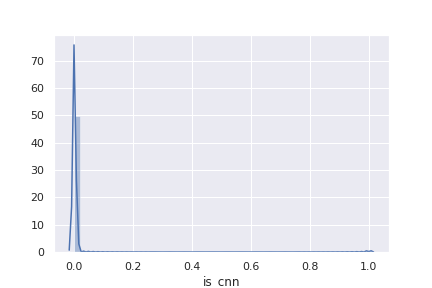

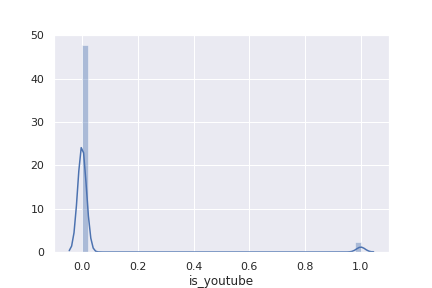

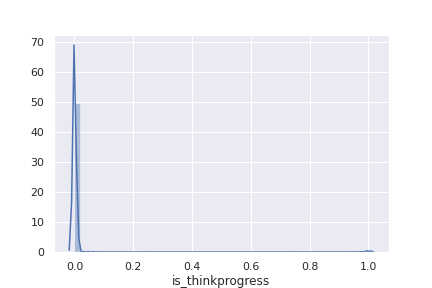

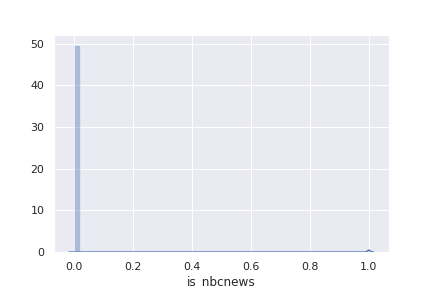

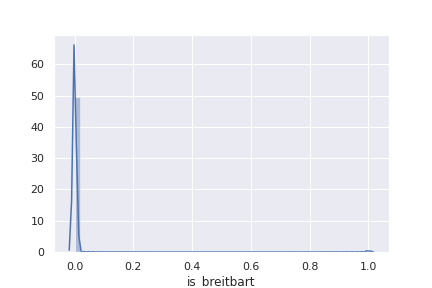

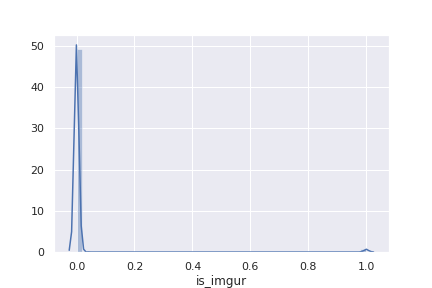

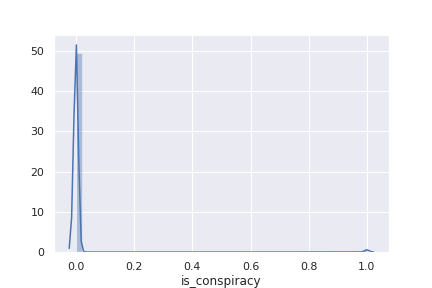

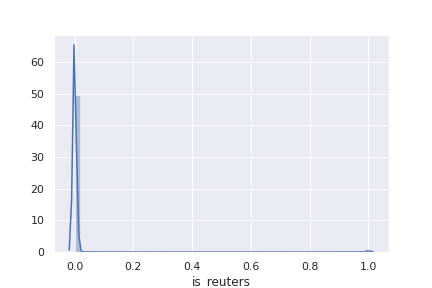

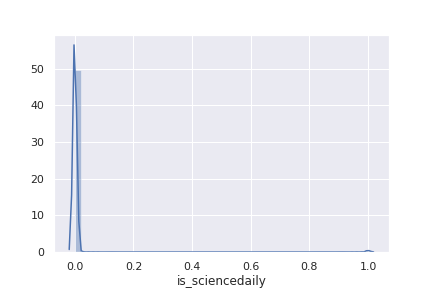

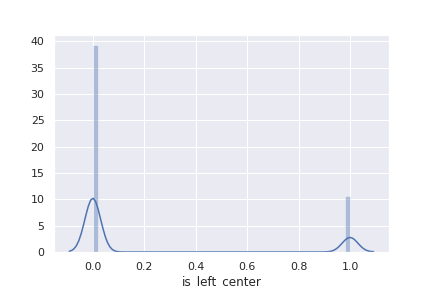

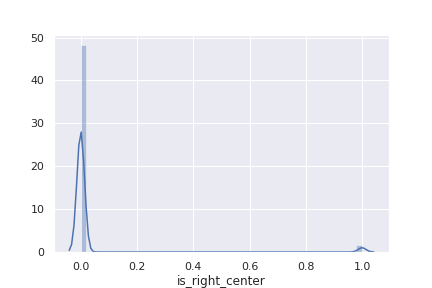

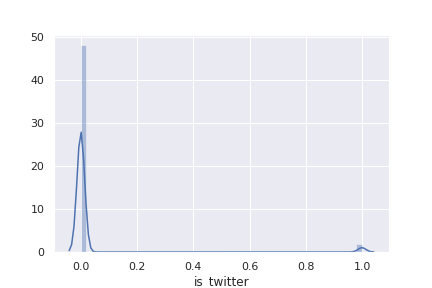

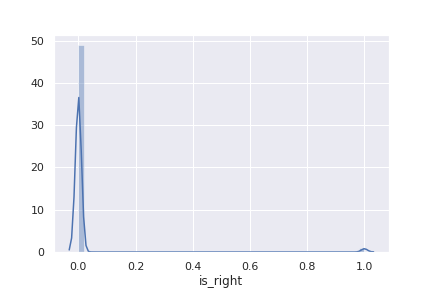

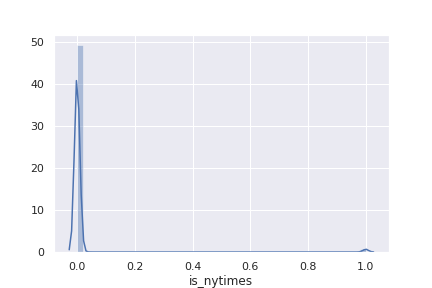

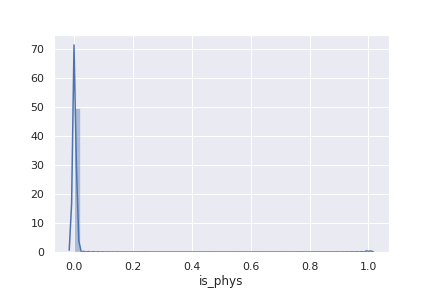

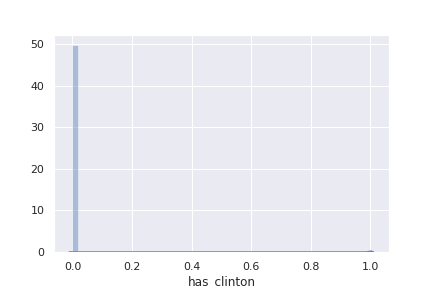

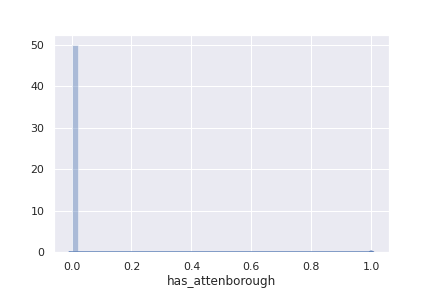

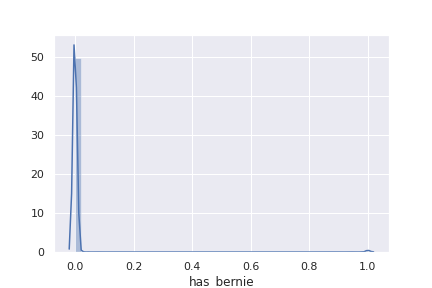

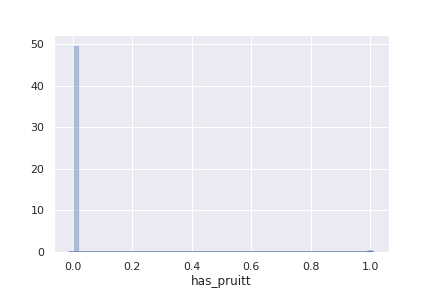

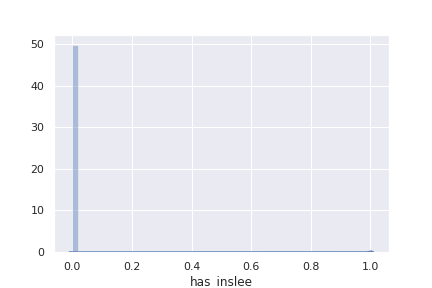

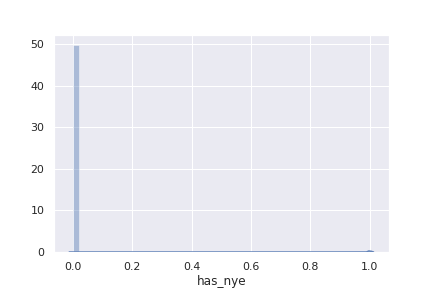

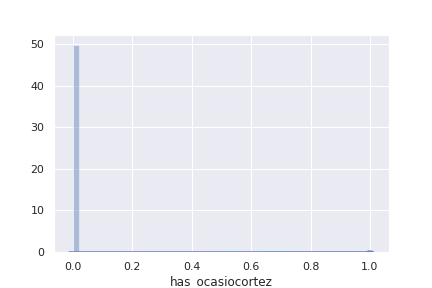

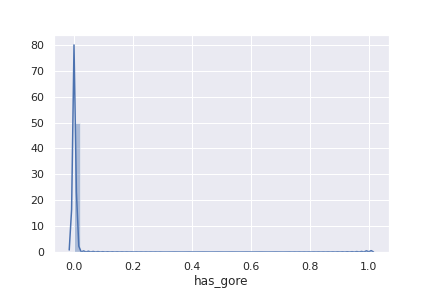

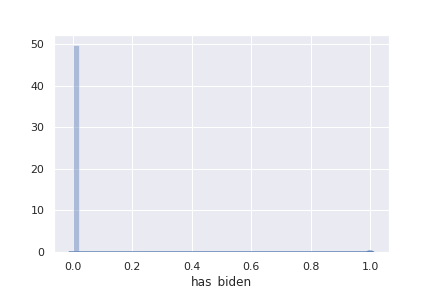

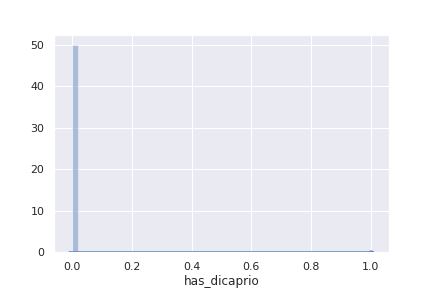

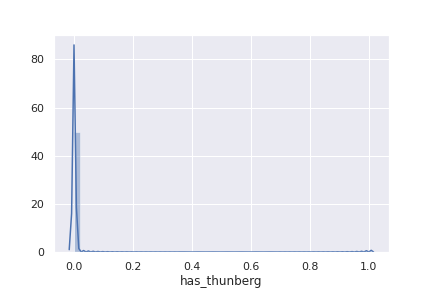

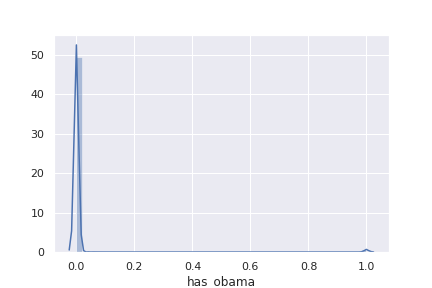

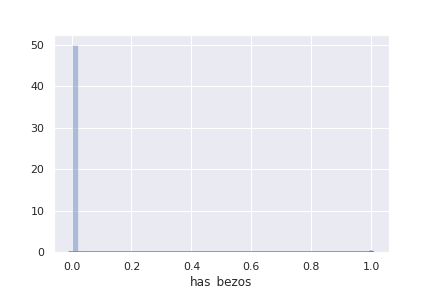

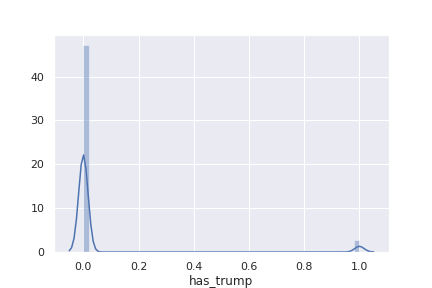

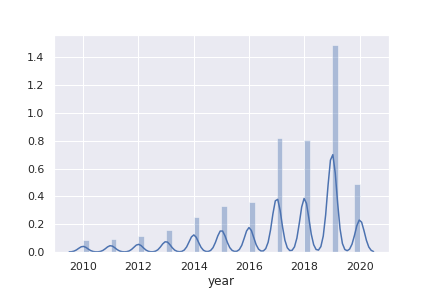

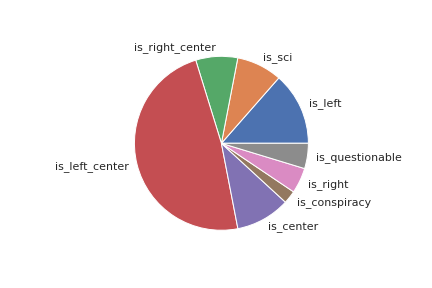

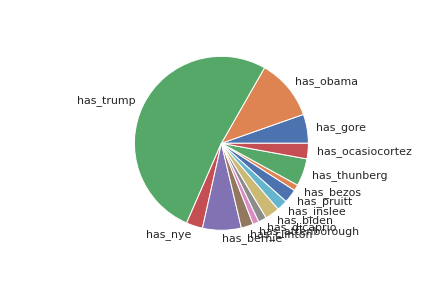

<Figure size 432x288 with 0 Axes>

In [17]:
DG.plot_features(ipython_disp=True)

These figures are saved to a `/figs` subdirectory in the output directory (`posts_with_words.pkl_out`) regardless of whether `ipython_disp` is set to `True`.

Now let's do some linear regression. We can create a `LinReg` instance, which needs `base_df` (the data to regress), `base_df_name` (a short description of the data to regress), `ind_vars` (a list with the names of columns from `base_df` to use as features), and `dep_vars` (a list with the name(s) of dependent variables to use) (as indicated by the Error message below):

In [23]:
LR = LinReg()

TypeError: __init__() missing 6 required positional arguments: 'base_df', 'base_df_name', 'ind_vars', 'dep_vars', 'subsets', and 'data_dir'

We can use `dg_data` (which stores `DG.get_data()`) as the argument for `base_df`. 
To determine what to pass to `ind_vars`, we can examine `DG.get_feats_dict()` to see what the names of all the different 
types of features are:

In [22]:
DG.get_feats_dict()

{'length': {'log_len'},
 'affect': {'NRC_arousal',
  'NRC_dom',
  'NRC_val',
  'achievement',
  'benevolence',
  'conformity',
  'emo_anger',
  'emo_disgust',
  'emo_fear',
  'emo_joy',
  'emo_sadness',
  'emo_surprise',
  'emo_trust',
  'hedonism',
  'power',
  'security',
  'self_direction',
  'stimulation',
  'tb_pol',
  'tradition',
  'universalism',
  'vader_cpd',
  'vader_neg',
  'vader_pos',
  'vice_authority',
  'vice_fairness',
  'vice_harm',
  'vice_loyalty',
  'vice_purity',
  'virtue_authority',
  'virtue_fairness',
  'virtue_harm',
  'virtue_loyalty',
  'virtue_purity'},
 'affect_cat': {'achievement_cat',
  'benevolence_cat',
  'conformity_cat',
  'emo_anger_cat',
  'emo_disgust_cat',
  'emo_fear_cat',
  'emo_joy_cat',
  'emo_sadness_cat',
  'emo_surprise_cat',
  'emo_trust_cat',
  'hedonism_cat',
  'power_cat',
  'security_cat',
  'self_direction_cat',
  'stimulation_cat',
  'tb_pol',
  'tradition_cat',
  'universalism_cat',
  'vader_cpd',
  'vader_neg_cat',
  'vader_pos_

Now we can initialize our linear regression with these inputs:

In [18]:
LR = LinReg(dg_data,'default_post_data','')

TypeError: __init__() missing 6 required positional arguments: 'base_df', 'base_df_name', 'ind_vars', 'dep_vars', 'subsets', and 'data_dir'

Before we can fit a regression model, we need to do the following:
* check for multicollinearity using the `get_VIF()` function,
* create the regression formulas interpretable by the statsmodels API using `get_formulas()`,
* prepare the dependent variables using `get_Ys()` (log transform for most cases),
* create subsets of `base_df` according to those listed in `self.subsets`, each of which will get its own fitted models

In [ ]:
LR.get_VIF()

Now we see that `self.collinear_feats` has been updated:

In [ ]:
LR.__dict__['collinear_feats']

In [ ]:
LR.get_Ys()

In [ ]:
LR.get_formulas()

In [ ]:
LR.get_sub_frames()

In [ ]:
LR.batch_regress()

In [ ]:
LR.get_significant_results().to_csv(os.path.join(DG.__dict__['out_dir'],'sig_results.tsv'),sep='\t',header=True,index=False)

In [ ]:
# do some plotting
for subset in LR.__dict__['subsets']:
    for feat_type in ['length', 'affect_cat', 'ling_cat', 'url', 'people', 'time']:
        feature_set = DG.__dict__['feats_dict'][feat_type]
        savename = os.path.join(DG.__dict__['out_dir'],'figs','{}_{}_effects'.format(subset,feat_type))
        LR.plot_coefficients(feature_set,subset,savename)